In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="NXSBTC", time="2021-01-15 17:00:08", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    start: pd.Timestamp = pump.time.floor("1h") - lookback_delta
    end: pd.Timestamp = pump.time.floor("1h")

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(
                ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name
            )
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")

    df = df[
        (df["time"] >= start) & (df["time"] < end - timedelta(minutes=1))
    ].reset_index(drop=True)

    return df

In [4]:
df: pd.DataFrame = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["price"] * df["qty"]
df.head()

,price,qty,time,isBuyerMaker,quote
0,0.000011,1.0,2020-12-16 17:00:21.207,True,0.000011
1,0.000011,9.0,2020-12-16 17:00:21.207,True,0.000100
2,0.000011,216.0,2020-12-16 17:00:22.118,False,0.002415
3,0.000011,3.0,2020-12-16 17:00:30.952,False,0.000034
4,0.000011,10.0,2020-12-16 17:01:01.211,True,0.000112


In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]

df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
    # Add BTC slippage
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0

df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long
0,2020-12-16 17:00:21.207,0.000011,0.000011,0.000011,0.000011,-10.0,10.0,-0.000111,0.000111,False
1,2020-12-16 17:00:22.118,0.000011,0.000011,0.000011,0.000011,216.0,216.0,0.002415,0.002415,True


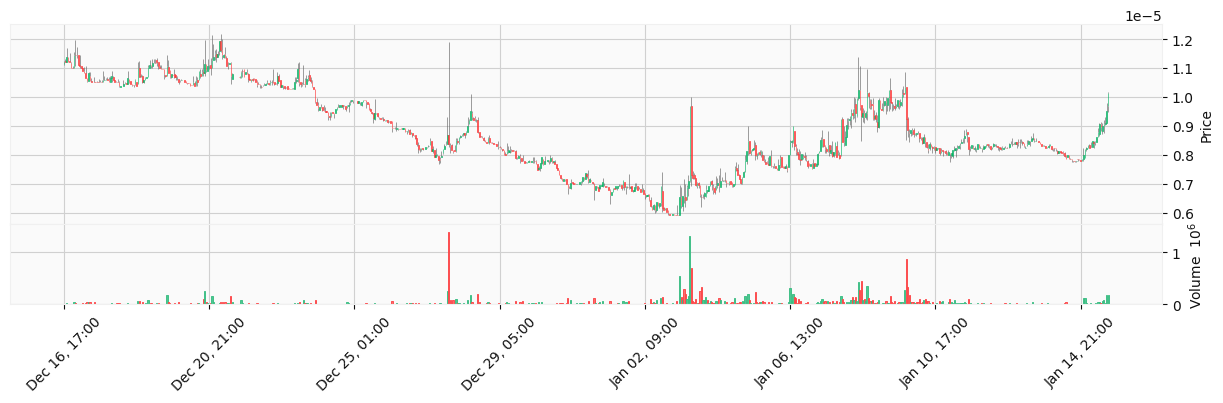

In [6]:
import mplfinance as mpl

df_candles: pd.DataFrame = df_trades.resample(rule="1h", on="time").agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    volume=("qty_abs", "sum")
)

mpl.plot(
    df_candles, type="candle", style="yahoo", volume=True, figsize=(16, 4), warn_too_much_data=int(1e10)
)

<h2>Log returns features</h2>

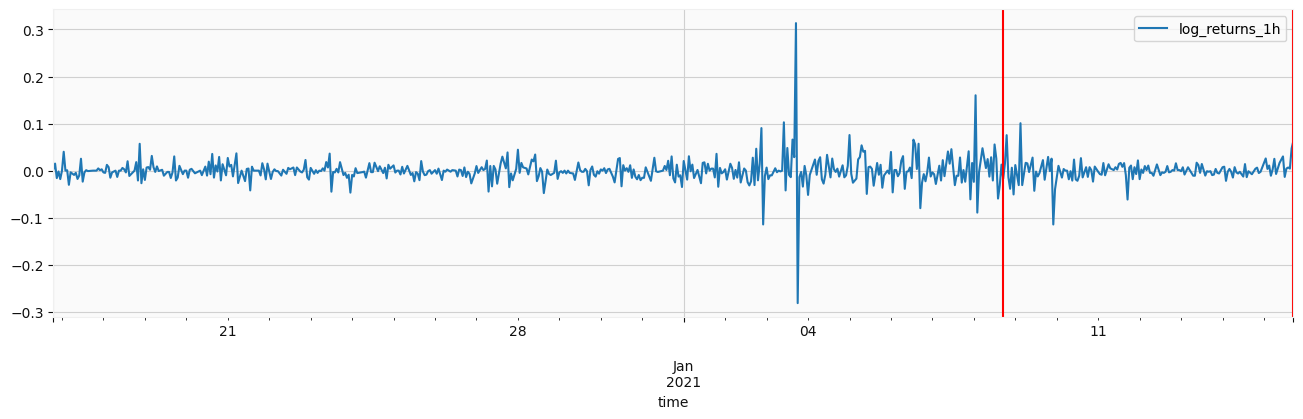

In [35]:
df_log_returns: pd.DataFrame = df_trades.resample(
    rule="1h", on="time", label="right", closed="right"
).agg(
    qty_abs_1h=("qty_abs", "sum"),
    price_first=("price_first", "first"),
    price_last=("price_last", "last"),
    num_trades_1h=("qty_sign", "count"),
    quote_abs_1h=("quote_abs", "sum"),
)

# calculate log returns
df_log_returns["price_last"] = df_log_returns["price_last"].ffill()
df_log_returns["log_returns_1h"] = np.log(
    df_log_returns["price_last"] / df_log_returns["price_last"].shift(1)
)
df_log_returns = df_log_returns[df_log_returns["log_returns_1h"].notna()]
df_log_returns = df_log_returns.reset_index()

df_log_returns.plot(x="time", y="log_returns_1h", figsize=(16, 4))

plt.axvline(x=pump.time, color="red")
plt.axvline(x=pump.time.floor("1h") - timedelta(days=7), color="red")

plt.show()

In [39]:
offsets: List[timedelta] = [
    timedelta(days=days) for days in [1, 7, 14, 30]
]

labels: List[str] = ["1d", "7d", "14d", "30d"]

log_returns_features = {}

df_log_returns_30d = df_log_returns[df_log_returns["time"] > pump.time.floor("1h") - timedelta(days=30)].copy()

log_returns_mean_30d: float = df_log_returns_30d["log_returns_1h"].mean()
log_returns_std_30d: float = df_log_returns_30d["log_returns_1h"].std()


for offset, label in zip(offsets, labels):
    df_window: pd.DataFrame = df_log_returns[
        df_log_returns["time"] > pump.time.floor("1h") - offset
    ].copy()

    log_returns_features[f"z_score_ts_log_returns_1h_{label}"] = df_window["log_returns_1h"].mean() / log_returns_std_30d
    log_returns_features[f"std_log_returns_1h_{label}"] = df_window["log_returns_1h"].std()

    log_returns_features[f"skew_log_returns_1h_{label}"] = df_window["log_returns_1h"].skew()
    log_returns_features[f"skew_log_returns_1h_{label}"] = df_window["log_returns_1h"].kurt()

log_returns_features

{'z_score_ts_log_returns_1h_1d': 0.4225123929591655,
 'std_log_returns_1h_1d': 0.017860010015011783,
 'skew_log_returns_1h_1d': 2.114510971715545,
 'z_score_ts_log_returns_1h_7d': 0.019758252159562874,
 'std_log_returns_1h_7d': 0.02034644529835943,
 'skew_log_returns_1h_7d': 10.226026080758015,
 'z_score_ts_log_returns_1h_14d': 0.04244873054655139,
 'std_log_returns_1h_14d': 0.03542572380788693,
 'skew_log_returns_1h_14d': 30.880864955710454,
 'z_score_ts_log_returns_1h_30d': -0.005149622929364562,
 'std_log_returns_1h_30d': 0.026320934447500607,
 'skew_log_returns_1h_30d': 48.804977945034125}

<h4>Number of empty trading hours</h4>

In [56]:
df_bars_15m: pd.DataFrame = df_trades.resample(
    on="time", rule="15min", label="left", closed="left"
).agg(
    num_trades=("quote_abs", "count")
).reset_index()

df_bars_15m.head()

,time,num_trades
0,2020-12-16 17:00:00,17
1,2020-12-16 17:15:00,28
2,2020-12-16 17:30:00,25
3,2020-12-16 17:45:00,16
4,2020-12-16 18:00:00,26


In [57]:
time_features = {}

for offset, label in zip(offsets, labels):
    df_window: pd.DataFrame = df_bars_15m[
        df_bars_15m["time"] > pump.time.floor("1h") - offset
    ].copy()

    num_empty_trading_hours: int = df_window[df_window["num_trades"] == 0].shape[0]
    overall_trading_hours: int = df_window.shape[0]

    time_features[f"share_empty_trading_hours_{label}"] = num_empty_trading_hours / overall_trading_hours

time_features

{'share_empty_trading_hours_1d': 0.042105263157894736,
 'share_empty_trading_hours_7d': 0.040238450074515646,
 'share_empty_trading_hours_14d': 0.04169769173492182,
 'share_empty_trading_hours_30d': 0.07572073636679402}

<h2>Quote quantity features</h2>

In [100]:
features = {}

for offset, label in zip(offsets, labels):
    df_window: pd.DataFrame = df_trades[df_trades["time"] >= pump.time.floor("1h") - offset].copy()
    
    long_whale_quantile_999 = df_window[df_window["is_long"]]["quote_abs"].quantile(.999)
    short_whale_quantile_999 = df_window[~df_window["is_long"]]["quote_abs"].quantile(.999)
    whale_quantile_999 = df_window["quote_abs"].quantile(.999)
    
    long_whale_quantile_99 = df_window[df_window["is_long"]]["quote_abs"].quantile(.99)
    short_whale_quantile_99 = df_window[~df_window["is_long"]]["quote_abs"].quantile(.99)
    whale_quantile_999 = df_window["quote_abs"].quantile(.99)

    long_whale_quantile_95 = df_window[df_window["is_long"]]["quote_abs"].quantile(.95)
    short_whale_quantile_95 = df_window[~df_window["is_long"]]["quote_abs"].quantile(.95)
    whale_quantile_999 = df_window["quote_abs"].quantile(.99)


    features[f"long_overall_quantile_999_ratio_{label}"] = long_whale_quantile_999 / whale_quantile_999
    features[f"short_overall_quantile_999_ratio_{label}"] = short_whale_quantile_999 / whale_quantile_999

    features[f"long_quantile_99_999_ratio_{label}"] = long_whale_quantile_999 / long_whale_quantile_99
    features[f"short_quantile_99_999_ratio_{label}"] = short_whale_quantile_999 / short_whale_quantile_99

    features[f"long_quantile_95_99_ratio_{label}"] = long_whale_quantile_95 / long_whale_quantile_99
    features[f"short_quantile_95_99_ratio_{label}"] = short_whale_quantile_95 / short_whale_quantile_99

In [101]:
features

{'long_overall_quantile_999_ratio_1d': 2.569021384306133,
 'short_overall_quantile_999_ratio_1d': 1.8781252484787838,
 'long_quantile_99_999_ratio_1d': 2.1254918671883956,
 'short_quantile_99_999_ratio_1d': 2.98904658843825,
 'long_quantile_95_99_ratio_1d': 0.257770372324377,
 'short_quantile_95_99_ratio_1d': 0.32124962844900556,
 'long_overall_quantile_999_ratio_7d': 2.2796187799791787,
 'short_overall_quantile_999_ratio_7d': 3.5606407626334406,
 'long_quantile_99_999_ratio_7d': 2.3705634257728243,
 'short_quantile_99_999_ratio_7d': 3.3227329609570937,
 'long_quantile_95_99_ratio_7d': 0.2752933736682353,
 'short_quantile_95_99_ratio_7d': 0.30472908779040686,
 'long_overall_quantile_999_ratio_14d': 2.4152373722434732,
 'short_overall_quantile_999_ratio_14d': 3.0117853689865144,
 'long_quantile_99_999_ratio_14d': 2.4456936613711453,
 'short_quantile_99_999_ratio_14d': 2.992470410717531,
 'long_quantile_95_99_ratio_14d': 0.28642837699917156,
 'short_quantile_95_99_ratio_14d': 0.309302697

<h3>Power law</h3>

In [102]:
from scipy.stats import powerlaw

In [128]:
rv = powerlaw.fit(df_trades["quote_abs"])
alpha = rv[0]
alpha

0.14286387813663443

In [131]:
powerlaw_features = {}

for offset, label in zip(offsets, labels):
    df_window: pd.DataFrame = df_trades[df_trades["time"] >= pump.time.floor("1h") - offset].copy()
    powerlaw_features[f"powerlaw_alpha_overall_{label}"]= powerlaw.fit(df_window["quote_abs"])[0]
    powerlaw_features[f"powerlaw_alpha_long_{label}"]= powerlaw.fit(
        df_window[df_window["is_long"]]["quote_abs"]
    )[0]
    powerlaw_features[f"powerlaw_alpha_short_{label}"] = powerlaw.fit(
        df_window[~df_window["is_long"]]["quote_abs"]
    )[0]


powerlaw_features

{'powerlaw_alpha_overall_1d': 0.1875767551359863,
 'powerlaw_alpha_long_1d': 0.1829729119682013,
 'powerlaw_alpha_short_1d': 0.1933014292874729,
 'powerlaw_alpha_overall_7d': 0.14796169196599326,
 'powerlaw_alpha_long_7d': 0.1798037036952712,
 'powerlaw_alpha_short_7d': 0.1489932612396152,
 'powerlaw_alpha_overall_14d': 0.15010911465133098,
 'powerlaw_alpha_long_14d': 0.15565953250554693,
 'powerlaw_alpha_short_14d': 0.15006648640171152,
 'powerlaw_alpha_overall_30d': 0.14286387813663443,
 'powerlaw_alpha_long_30d': 0.15497308466610302,
 'powerlaw_alpha_short_30d': 0.1383749497208941}